# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.554368,False,0.194190
1,0.312107,True,5.375545
2,-0.432204,False,-0.963408
3,-0.416231,True,6.597549
4,-1.054166,False,-0.492801
...,...,...,...
995,-0.292648,False,0.488714
996,-2.306151,False,0.827960
997,-1.927602,True,4.850829
998,-0.699479,False,0.780535


<AxesSubplot:xlabel='v0'>

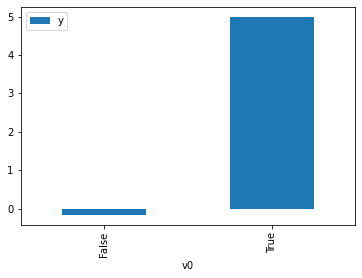

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

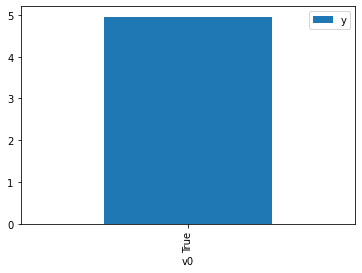

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.775427,False,-2.516631,0.567831,1.761088
1,-0.859360,False,0.131265,0.577858,1.730530
2,-0.112451,False,-0.423231,0.487332,2.051990
3,1.787187,False,0.256811,0.273257,3.659553
4,-1.777950,False,-0.240693,0.681891,1.466510
...,...,...,...,...,...
995,0.449551,False,0.756735,0.419440,2.384133
996,-0.495885,False,-0.492525,0.534078,1.872386
997,0.325575,False,0.815129,0.434247,2.302837
998,-1.011572,False,-0.467873,0.595874,1.678208


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.211995,True,6.072981,0.380800,2.626052
1,-0.775903,True,5.398658,0.432112,2.314213
2,1.049796,True,5.325802,0.649795,1.538948
3,-1.458900,True,4.844858,0.352812,2.834374
4,0.727436,True,3.805028,0.613192,1.630811
...,...,...,...,...,...
995,0.552600,True,6.322926,0.592760,1.687024
996,0.998858,True,5.430310,0.644114,1.552519
997,-0.707247,True,5.890037,0.440356,2.270890
998,-1.438818,True,4.064720,0.355054,2.816476


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                              6883.
Date:                Fri, 19 Aug 2022   Prob (F-statistic):                        0.00
Time:                        04:00:40   Log-Likelihood:                         -1402.6
No. Observations:                1000   AIC:                                      2809.
Df Residuals:                     998   BIC:                                      2819.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3679      0.030     12.126      0.000       0.308       0.427
x2             5.0906      0.044    116.054      0.000       5.005       5.177
==============================================================================
Omnibus:                        1.490   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.475   Jarque-Bera (JB):                1.516
Skew:                          -0.093   Prob(JB):                        0.469
Kurtosis:                       2.962   Cond. No.                         1.45
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""